# Car Price Prediction

- Student name: Jagandeep Singh
- Student pace: full-time
- Scheduled project review date: 31 July
- Instructor name: Sean Wilson

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-deep')
plt.rcParams.update({'font.size': 15})

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
df.shape

(458213, 26)

In [4]:
len(df[df.price == 0])

33753

## Data Cleaning

In [5]:
# Removing rows with missing price and year
df.drop(df[df['price'] == 0].index, inplace = True) 
df.drop(df[df['year'].isna()].index, inplace = True) 
df.drop(df[df['year'] == 2021].index, inplace = True)
df.drop([496], inplace = True)
df.drop(df[df.odometer > 500000].index, inplace = True)

In [6]:
# Changing type of year to int
df['year'] = df['year'].astype(int)
df['year'].dtype

dtype('int32')

In [7]:
year_med =  dict(df.groupby('year')['odometer'].median())

In [8]:
# Imputing missing values in odometer with median odometer of each year cars
df['odometer'] = df['odometer'].fillna(df['year'].apply(lambda x: year_med.get(x)))

In [9]:
# Removing the leftover missing values in odometer because no information available for those years
df.drop(df[df['odometer'].isna()].index, inplace = True) 

In [10]:
df.shape

(421812, 26)

In [11]:
# Dropping cars with price less than 1000 with miles less than 60,000 and model year greater than 2010
df.drop(df[(df.price < 1000 ) & (df.odometer < 60000 ) & (df.year > 2010)].index, inplace = True)
df.drop(df[(df.price < 200)].index, inplace = True)
df.drop(df[(df.price > 50000)].index, inplace = True)

In [12]:
df.shape

(405261, 26)

In [13]:
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [14]:
# Dropping rows with missing cylinders, transmission and drive
df.drop(df[(df['cylinders'].isna()) & (df['transmission'].isna()) & (df['drive'].isna())].index, inplace = True)

In [15]:
df['cylinders'] = df['cylinders'].apply(lambda x: x[0] if not pd.isnull(x) else np.nan)

In [16]:
# Changing cylinders of tesla cars to 0
df.loc[df.manufacturer == 'tesla', 'cylinders'] = 0
df.cylinders.fillna(0, inplace = True)
df.cylinders =  df.cylinders.replace('o', 0)

In [17]:
df['cylinders'] = df['cylinders'].astype(int)


In [18]:
# Changing cylinder of all 2019 honda accords to 4
df.loc[((df.manufacturer == 'honda') & (df.year == 2019) & (df.model == 'accord')), 'cylinders'] = 4

In [19]:
df.loc[((df.manufacturer == 'honda') & (df.year == 2020) & (df.model == 'accord')),'cylinders'] = 4

In [20]:
# Dropping unwanted columns
df.drop(['id', 'url', 'region_url', 'VIN', 'lat', 'long','image_url', 'region', 'model','state', 'posting_date', 'Unnamed: 0'], axis = 1, inplace = True) 

In [21]:
df.shape

(404292, 14)

In [22]:
df.isna().sum()

price                0
year                 0
manufacturer     13553
condition       158026
cylinders            0
fuel              2106
odometer             0
title_status      1361
transmission       740
drive           116400
size            281950
type             99911
paint_color     119149
description         42
dtype: int64

In [23]:
df.condition.replace('like new', 'excellent', inplace = True)
df.condition.replace('new', 'excellent', inplace = True)

In [24]:
df.condition.value_counts()

excellent    127147
good         110967
fair           7546
salvage         606
Name: condition, dtype: int64

In [25]:
df.fuel.fillna('gas', inplace = True)

In [26]:
df.fuel.value_counts()

gas         361438
diesel       23312
other        12310
hybrid        5176
electric      2056
Name: fuel, dtype: int64

In [27]:
df.transmission.value_counts()

automatic    349195
other         29694
manual        24663
Name: transmission, dtype: int64

In [28]:
# Getting transmission from description
df.loc[(df['description'].str.contains('automatic transmission')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('manual transmission')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('automatic transmission')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('manual transmission')) & (df['transmission'].isna()), "transmission"] = "manual"

df.loc[(df['description'].str.contains('Automatic Transmission')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('Manual Transmission')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('Automatic Transmission')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('Manual Transmission')) & (df['transmission'].isna()), "transmission"] = "manual"

df.loc[(df['description'].str.contains('AUTOMATIC TRANSMISSION')) & (df['transmission'] == 'other'), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('MANUAL TRANSMISSION')) & (df['transmission'] == 'other'), "transmission"] = "manual"
df.loc[(df['description'].str.contains('AUTOMATIC TRANSMISSION')) & (df['transmission'].isna()), "transmission"] = "automatic"
df.loc[(df['description'].str.contains('MANUAL TRANSMISSION')) & (df['transmission'].isna()), "transmission"] = "manual"


In [29]:
# Assuming most cars have automatic transmission
df.transmission.fillna('automatic', inplace = True)
df.transmission.replace('other', 'automatic', inplace = True)

In [30]:
df.transmission.value_counts()

automatic    379548
manual        24744
Name: transmission, dtype: int64

In [31]:
df.isna().mean()

price           0.000000
year            0.000000
manufacturer    0.033523
condition       0.390871
cylinders       0.000000
fuel            0.000000
odometer        0.000000
title_status    0.003366
transmission    0.000000
drive           0.287911
size            0.697392
type            0.247126
paint_color     0.294710
description     0.000104
dtype: float64

In [32]:
# Dropping cars with less than 10 miles and more than 300,000 miles.
df.drop(df[df.odometer < 10].index, inplace = True) 
df.drop(df[df.odometer > 300000].index, inplace = True) 

In [33]:
df.shape

(400724, 14)

### Hypothesis Tests

#### First Hypothesis test

In [34]:
# Null Hypothesis - H0: Mean price of diesel is equal to the mean price of gas
# Alternative Hypothesis - HA: Mean price of diesel is different than the mean price of gas

diesel = df[df.fuel == 'diesel'].price
gas = df[df.fuel == 'gas'].price

print(stats.ttest_ind(diesel, gas))

# Ttest_indResult(statistic=181.92229245543183, pvalue=0.0)

# Reject Null Hypthesis
# p-value << 0.05 
# Mean price of diesel is different than the mean price of gas


Ttest_indResult(statistic=138.31076906111912, pvalue=0.0)


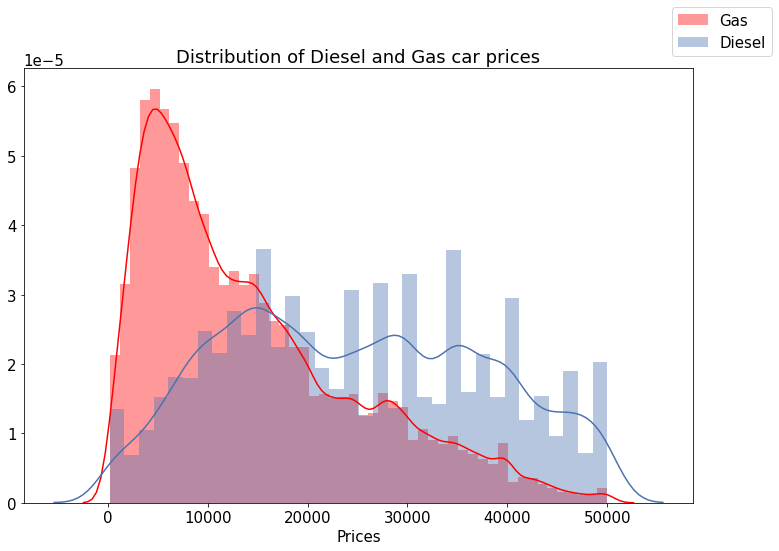

In [35]:
fig = plt.figure(figsize=(12,8))
sns.distplot(gas, color = 'red')
sns.distplot(diesel)
fig.legend(labels=['Gas','Diesel'])
plt.title('Distribution of Diesel and Gas car prices')
plt.xlabel('Prices')

plt.show()

#### Second Hypothesis test

In [36]:
#Null Hypothesis - H0: Mean price of rwd is lesser or equal than the mean price of fwd
#Alternative Hypothesis - HA: Mean price of rwd is greater than the mean price of fwd

rwd = df[df.drive == 'rwd'].price
fwd = df[df.drive == 'fwd'].price

print(stats.ttest_ind(rwd, fwd))

# Ttest_indResult(statistic=109.39720387405556, pvalue=0.0)

# Reject Null Hypthesis
# p-value << 0.05 
# Mean price of rwd is greater than the mean price of fwd

Ttest_indResult(statistic=166.94590200097966, pvalue=0.0)


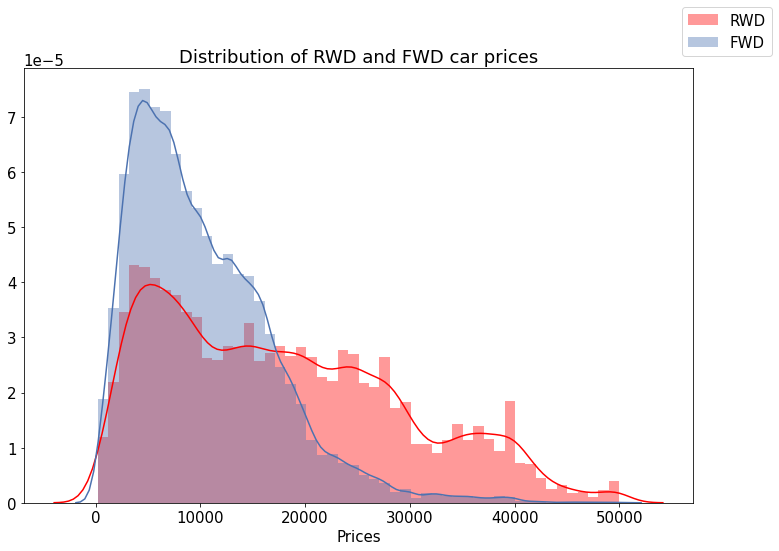

In [37]:
fig = plt.figure(figsize=(12,8))
sns.distplot(rwd, color = 'red')
sns.distplot(fwd)
fig.legend(labels=['RWD','FWD'])
plt.title('Distribution of RWD and FWD car prices')
plt.xlabel('Prices')

plt.show()

#### Third Hypthesis test

In [38]:
# Null Hypothesis: There is s
# Alt-Hypothesis: There is a significant relation between price and condition.


anova = ols('price~condition', data=df).fit()
anova_table = sm.stats.anova_lm(anova, type=2)
print(anova_table)

# p-value = 0
# F-stat = 2592.142181
# Reject Null Hypothesis
# There is a significant relation between price and condition.

                 df        sum_sq       mean_sq            F  PR(>F)
condition       3.0  1.437276e+12  4.790921e+11  4148.225406     0.0
Residual   244124.0  2.819468e+13  1.154933e+08          NaN     NaN


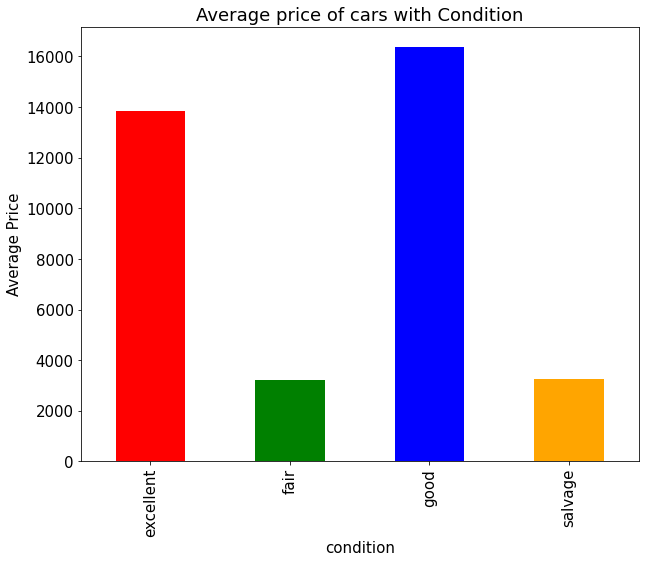

In [39]:
plt.figure(figsize=(10,8))
df.groupby('condition').price.mean().plot(kind = 'bar',color=['red', 'green', 'blue', 'orange'])
plt.title('Average price of cars with Condition')
plt.ylabel('Average Price')
plt.show()

### Visualizations

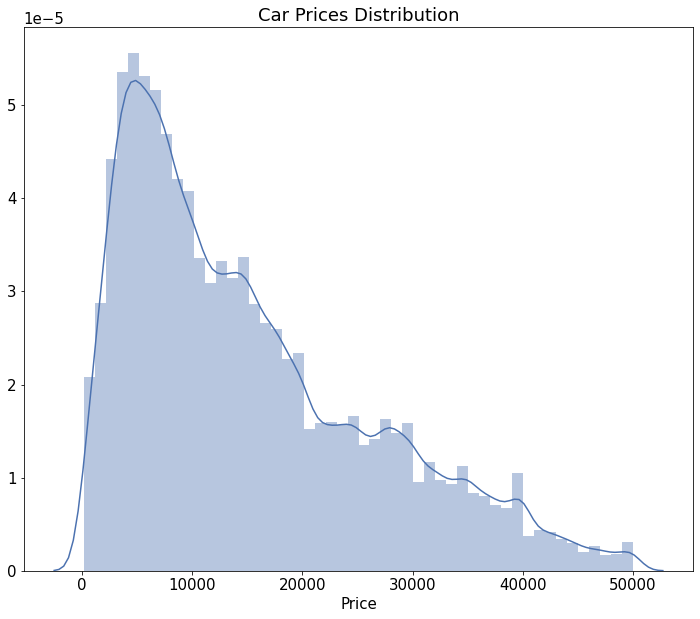

In [40]:
plt.figure(figsize=(12,10))
sns.distplot(df.price)
plt.title('Car Prices Distribution')
plt.xlabel('Price')
plt.show()

<ipython-input-41-590f23a1c942>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


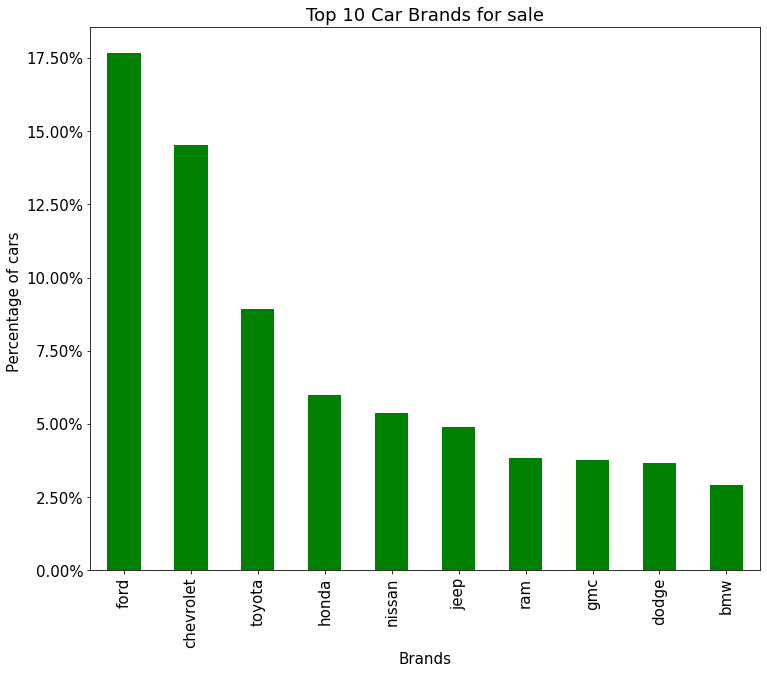

In [41]:
plt.figure(figsize=(12,10))
ax = df['manufacturer'].value_counts(normalize = True).head(10).plot(kind='bar', color = 'green')
plt.title('Top 10 Car Brands for sale')
plt.xlabel('Brands')
plt.ylabel('Percentage of cars ')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

<ipython-input-42-0186ca4d677e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


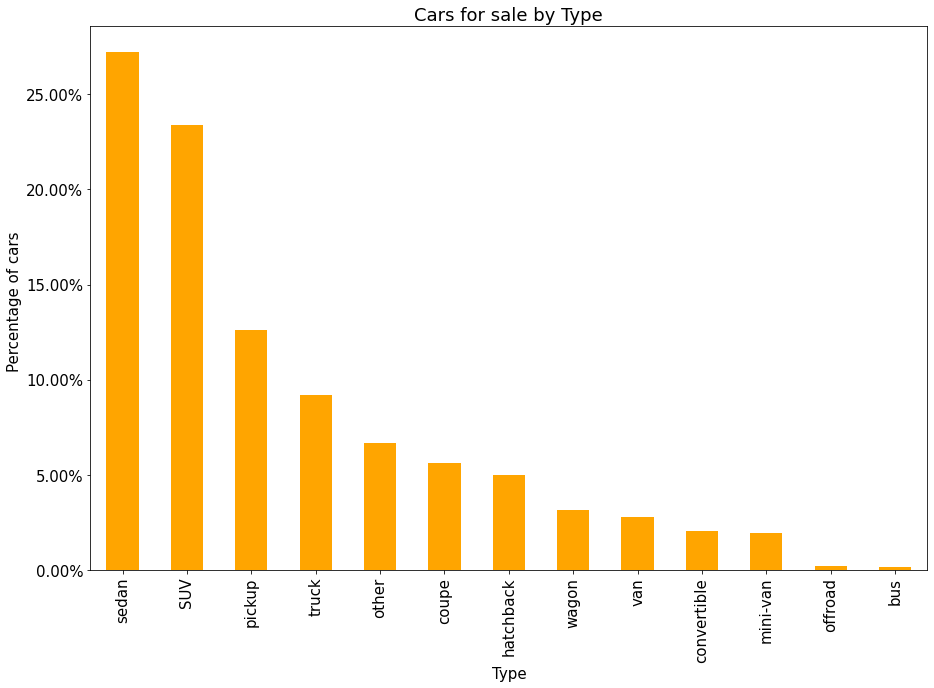

In [42]:
plt.figure(figsize=(15,10))
ax = df['type'].value_counts(normalize = True).plot(kind='bar', color = 'orange')
plt.title('Cars for sale by Type')
plt.xlabel('Type')
plt.ylabel('Percentage of cars ')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Text(0.5, 1.0, 'Number of cars by Condition')

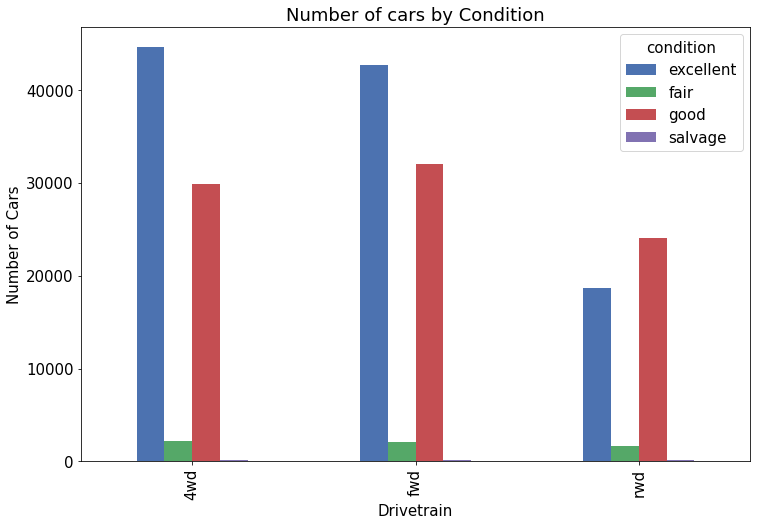

In [43]:

ax = df.groupby(['drive', 'condition']).price.count().unstack().plot(kind = 'bar',figsize = (12,8) )
plt.ylabel("Number of Cars")
plt.xlabel("Drivetrain")
plt.title('Number of cars by Condition')

Text(0, 0.5, 'Average miles')

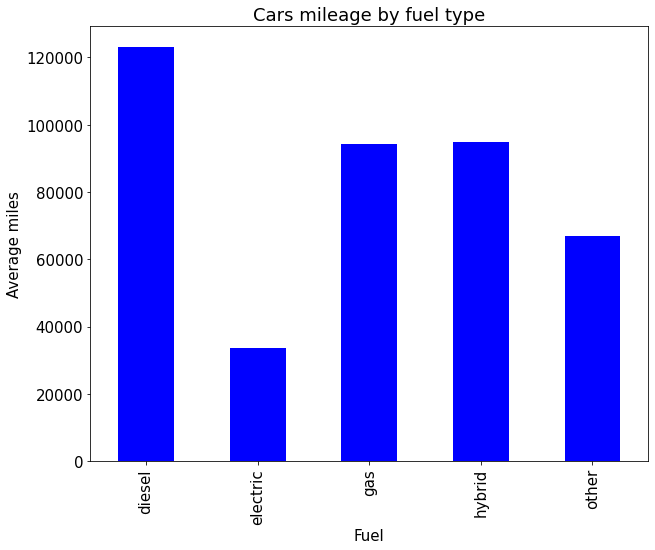

In [44]:
fig = plt.figure(figsize = (10,8))
ax = df.groupby([ 'fuel']).odometer.median().plot(kind = 'bar', color = 'blue');
plt.title('Cars mileage by fuel type')
plt.xlabel('Fuel')
plt.ylabel('Average miles')

Text(0.5, 12.199999999999989, 'Miles')

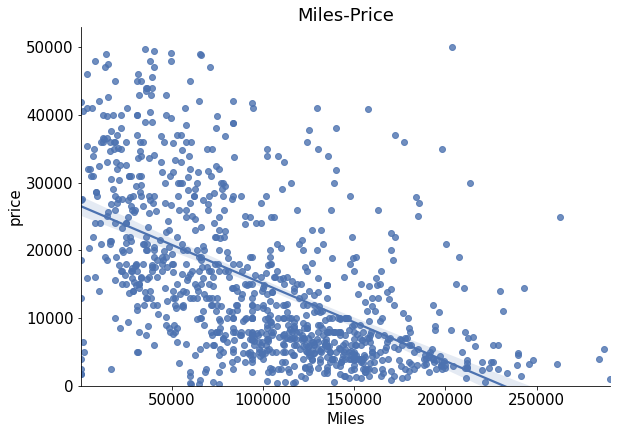

In [45]:
sample = df.sample(n = 1000)
sns.lmplot('odometer', 'price', data=sample[['price','odometer']],height = 6, aspect = 1.5)
plt.ylim(0, None);
plt.title('Miles-Price')
plt.xlabel('Miles')

Text(0.5, 1.0, 'Year-Price')

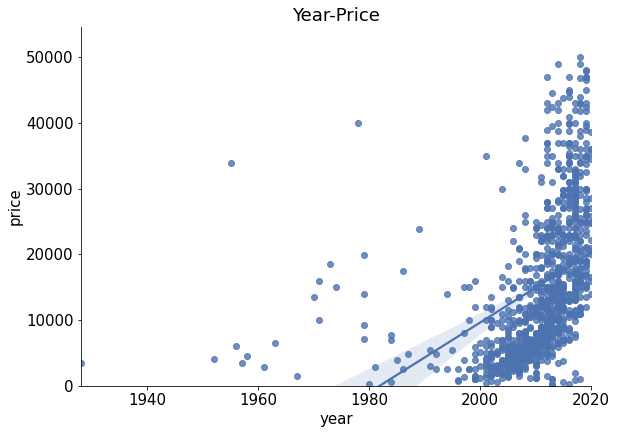

In [46]:
sample = df.sample(n = 1000)
sns.lmplot('year', 'price', data=sample[['price','year']],height = 6, aspect = 1.5)
plt.ylim(0, None);
plt.title('Year-Price')

####  Creating New Column for Leather seats from Description

In [47]:
df['leather_seats'] = np.where((df['description'].str.contains('leather')) |
                          (df['description'].str.contains('Leather'))|
                          (df['description'].str.contains('LEATHER')) , 1,0)

In [48]:
df['leather_seats'].sum()

102422

In [49]:
# Removing Description column
df.drop(['description'], axis = 1, inplace = True)


In [50]:
df.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,leather_seats
0,35990,2010,chevrolet,good,8,gas,32742.0,clean,automatic,rwd,NaN,other,NaN,0
1,7500,2014,hyundai,excellent,4,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,0
2,4900,2006,bmw,good,6,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,0
3,2000,1974,chevrolet,good,4,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,0
4,19500,2005,ford,excellent,8,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,1


In [52]:
# Putting clean data in a csv
df.to_csv('cleaned_vehicles.csv', index = False)